In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import config
from utils import compute_frames

In [2]:
import torch
from torch.utils.data import Dataset

# History dataset generation

In [3]:
# load legal amazon limits
am_bounds = gpd.read_file(config.AMAZON_FRONTIER_DATA)

In [4]:
# load frames idx detail
frames_idx = pd.read_csv(config.TR_FRAMES_IDX, index_col=0)

In [5]:
# load frames deforestation area history
deforestation = pd.read_csv(config.TR_DEFORESTATION, index_col=0)
deforestation["quarter_date"] = pd.to_datetime(deforestation["quarter_date"])

In [6]:
# counties
frames_county = pd.read_csv(config.TR_COUNTIES, index_col=0)
counties_defor = pd.read_csv(config.TR_COUNTIES_DEFOR, index_col=0)

## Create grid

In [7]:
# create limits history grid
time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in enumerate(config.TIME_STEPS):
    defor_area = (
        deforestation[
            deforestation["quarter_date"] == dt
        ].set_index("frame_id")["area"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0)
    time_grid[t, :, :] = defor_area.values.reshape(time_grid[0, :, :].shape)

In [8]:
time_grid.shape

(28, 1002, 778)

# Counties data

## Population and density

In [9]:
county_data = np.zeros((2, frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
county_data[0] = (
    frames_county.set_index("frame_id")["populacao"] +\
    pd.Series(0, index=frames_idx.index)
).fillna(0).\
    values.reshape(county_data.shape[1:])

county_data[1] = (
    frames_county.set_index("frame_id")["densidade"] +\
    pd.Series(0, index=frames_idx.index)
).fillna(0).\
    values.reshape(county_data.shape[1:])

## Deforestation

In [10]:
frames_counties_defor = pd.merge(
    counties_defor,
    frames_county[["frame_id", "county_id"]],
    on="county_id",
    how="right"
)
frames_counties_defor["quarter_date"] = pd.to_datetime(frames_counties_defor["quarter_date"])

In [11]:
# create limits history grid
counties_time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in tqdm(enumerate(config.TIME_STEPS)):
    defor_area = (
        frames_counties_defor[
            frames_counties_defor["quarter_date"] == dt
        ].set_index("frame_id")["area"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0)
    counties_time_grid[t, :, :] = defor_area.values.reshape(counties_time_grid[0, :, :].shape)

28it [00:06,  4.60it/s]


In [12]:
counties_time_grid.shape

(28, 1002, 778)

# Compute frame patches

A patch is squared set of unitary frames. The patch formation process consists in iterating through the full image on both axis computing the frames corresponding to each iteration.

In [13]:
out_condition = "borders"  # deforestation | borders

bundle_step = 32
patches = []
for ix in tqdm(list(range(frames_idx["x"].min(), frames_idx["x"].max()+1, bundle_step))):
    fx = ix + config.INPUT_BOXES_SIZE
    for iy in range(frames_idx["y"].min(), frames_idx["y"].max()+1, bundle_step):
        fy = iy + config.INPUT_BOXES_SIZE

        iframes = frames_idx[
            (frames_idx["x"] >= ix) & 
            (frames_idx["x"] < fx) &
            (frames_idx["y"] >= iy) &
            (frames_idx["y"] < fy)
        ]
        
        if out_condition == "borders":
            if iframes["in_borders"].mean() >= 0.5:  # condition: bundle has to be at least half inside borders
                patches.append(iframes.index)
                
        elif out_condition == "deforestation":
            out_of_borders_frames = len(set(iframes.index) - set(deforestation["frame_id"].values))
            if out_of_borders_frames < len(iframes):  # condition: bundle has to contain  some deforestation
                patches.append(iframes.index)        

100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


In [14]:
# remove patches that represent reduced regions
patches = [b for b in patches if (len(b)==len(patches[0]))]

In [15]:
len(patches)

441

In [16]:
patches[0]

Index([  288,   289,   290,   291,   292,   293,   294,   295,   296,   297,
       ...
       49356, 49357, 49358, 49359, 49360, 49361, 49362, 49363, 49364, 49365],
      dtype='int64', length=4096)

In [17]:
# generate region and check which patches intersect
region = compute_frames(am_bounds.total_bounds, config.BOX_SIDE, 200, 300, 500, 600)

41
42
43
44
45
53
54
55
56
57


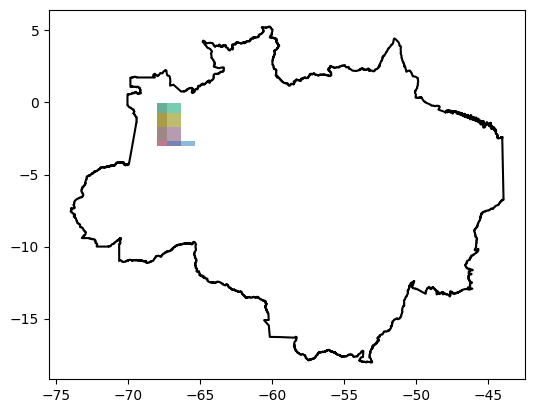

In [18]:
fig, ax = plt.subplots()
am_bounds.boundary.plot(ax=ax, color="black")
j = 0
for i, b in enumerate(patches):
    int_b = region[region["frame_id"].isin(b)]
    if len(int_b) > 0:
        int_b.plot(ax=ax, color=sns.color_palette()[j%10], alpha=.5)
        j+=1
        if j > 10:
            break
        print(i)
plt.show()

# Data Normalization

In [19]:
class BinaryMatrixData:

    def __init__(self):
        pass

    def fit(self, X):
        self.X = X.copy()

        # apply (-1, 1) range
        self.X[np.where(X>=1e-7)] = 1
        self.X = 2*(self.X - .5)

        # normalize to get zero mean
        self.multiplier = (self.X<0).sum() / (self.X>0).sum()
        self.X[np.where(self.X == 1)] = self.multiplier

        return self.X

    def transform(self, X):
        X_ = X.copy()

        # apply (-1, 1) range
        X_[np.where(X_>=1e-7)] = 1
        X_ = 2*(X_ - .5)

        # normalize to get zero mean
        X_[np.where(X_ == 1)] = self.multiplier

        return X_

In [20]:
time_grid.shape

(28, 1002, 778)

In [21]:
train_time_idx = range(8,20)
test_time_idx = range(20,28)

train_data = time_grid[train_time_idx, :, :]
test_data = time_grid[test_time_idx, :, :]

In [22]:
one_multiplicator_factor = np.log(
    (train_data <= 1e-7).sum() / (train_data > 1e-7).sum()
)

In [23]:
norm_pop = (county_data[0, :, :] - np.median(county_data[0, :, :])) / 1e5
norm_den = (county_data[1, :, :] - np.median(county_data[1, :, :])) / 30

county_data[0, :, :] = norm_pop
county_data[1, :, :] = norm_den

In [24]:
counties_time_grid = counties_time_grid / counties_time_grid[train_time_idx, :, :].std()

In [25]:
# loss function
def WeightedBinaryCrossEntropy(target, prediction):
    return -(one_multiplicator_factor*target*prediction.log() + (1-target)*((1-prediction).log()))

# Dataset & Dataloaders

In [26]:
len(patches) * (time_grid.shape[0] - 4)

10584

In [27]:
class CustomDataset(Dataset):
    def __init__(self, X, patches, frames_idx, county_data=None, county_defor=None):
        super(CustomDataset, self).__init__()

        self.patches = patches
        self.frames_idx = frames_idx
        self.X = X
        self.county_data = county_data
        self.county_defor = county_defor
        self.autor_window = 4
        self.ix = frames_idx["x"].min()
        self.iy = frames_idx["y"].min()

    def __len__(self):
        return len(self.patches) * (self.X.shape[0]-self.autor_window)

    def __getitem__(self, index):

        # get index info
        idx_patch = index // (self.X.shape[0] - self.autor_window)
        idx_time   = index % (self.X.shape[0] - self.autor_window)
        idx_frames = self.frames_idx.loc[self.patches[idx_patch]]

        # get input
        input_matrix = self.X[
            idx_time:idx_time+self.autor_window, 
            idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
            idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
        ]

        if self.county_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.county_data[
                    :,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.county_defor is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.county_defor[
                    idx_time:idx_time+self.autor_window,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        data = torch.tensor(input_matrix).float()

        # get output
        labels = torch.tensor(
            self.X[
                idx_time+self.autor_window, 
                idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
            ] > 1e-7
        ).float()
        return data, labels

In [28]:
train_data.shape, test_data.shape

((12, 1002, 778), (8, 1002, 778))

In [46]:
patches_sample_train = [patches[i] for i in np.random.choice(range(len(patches)), 100, replace=False)]
patches_sample_test = [patches[i] for i in np.random.choice(range(len(patches)), 10, replace=False)]

In [47]:
trainloader = torch.utils.data.DataLoader(
    CustomDataset(
        train_data, 
        patches_sample_train, 
        frames_idx, 
        county_data,
        counties_time_grid
    ),
    batch_size=40,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    CustomDataset(
        test_data, 
        patches_sample_test, 
        frames_idx, 
        county_data,
        counties_time_grid
    ),
    batch_size=1,
    shuffle=False
)

In [48]:
trainloader.__len__()*trainloader.batch_size, testloader.__len__()*testloader.batch_size

(800, 40)

# Baseline Model

Just test the metrics we get when always predicting zeros.

In [49]:
# baseline: all 50%
base_train_err = 0
for inputs, labels in trainloader:
    y_pred = torch.tensor(0.5*np.ones(labels.shape))
    # base_train_err -= (y_pred*labels).float().mean()
    base_train_err += WeightedBinaryCrossEntropy(labels, y_pred).detach().float().mean()
base_train_err = base_train_err / (len(trainloader)*trainloader.batch_size)
    
base_test_err = 0
for inputs, labels in testloader:
    y_pred = torch.tensor(0.5*np.ones(labels.shape))
    # base_test_err -= (y_pred*labels).float().mean()
    base_test_err += WeightedBinaryCrossEntropy(labels, y_pred).detach().float().mean()
base_test_err = base_test_err / (len(testloader)*testloader.batch_size)

print(f"Baseline: Train Loss = {base_train_err:.6f} | Test Loss = {base_test_err:.6f}")

Baseline: Train Loss = 0.018462 | Test Loss = 0.735048


# Model Implementation

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

ks = 7
 
class BasicConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.epoch = 0
        self.errs = []

        self.convolutional_layer = nn.Sequential(
            nn.Conv2d(4+2+4, 64, kernel_size=(ks,ks), stride=1, padding=int(ks/2)),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(ks,ks), stride=1, padding=int(ks/2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(ks,ks), stride=1, padding=int(ks/2)),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=(ks,ks), stride=1, padding=int(ks/2)),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        y = self.convolutional_layer(x)
        return y

In [51]:
# model initialization
model = BasicConvModel()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

In [52]:
# model.load_state_dict(torch.load(r"basic_cnn_003.pt"))

In [53]:
print(model)

BasicConvModel(
  (convolutional_layer): Sequential(
    (0): Conv2d(10, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(7, 7), stride=1, padding=3, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (7): Sigmoid()
  )
)


In [54]:
for data, target in trainloader:
    break

In [55]:
data.shape, target.shape

(torch.Size([40, 10, 64, 64]), torch.Size([40, 64, 64]))

In [56]:
pred = model(data)

In [57]:
target.min()

tensor(0.)

In [58]:
pred[0, 0, 0, 0], target[0, 0, 0]

(tensor(0.4577, grad_fn=<SelectBackward0>), tensor(0.))

In [59]:
pred.shape, target.shape

(torch.Size([40, 1, 64, 64]), torch.Size([40, 64, 64]))

In [60]:
(pred[:, 0, :, :]*target).shape

torch.Size([40, 64, 64])

In [61]:
(pred[:, 0, :, :] - target).multiply(np.exp(target)).shape

torch.Size([40, 64, 64])

In [63]:
# train loop
errs = []

def train(n_epochs):

    for epoch in range(n_epochs):
        print(f"\nEpoch {model.epoch}")
        if model.epoch >= 1:
            for inputs, labels in tqdm(trainloader):
                y_pred = model(inputs)[:, 0, :, :]
                # evaluate loss ignoring the borders
                # l = (y_pred - labels).multiply(np.exp(labels))
                # l = -y_pred*labels
                l = WeightedBinaryCrossEntropy(labels, y_pred)
                loss = l.mean()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        train_err = 0
        for inputs, labels in trainloader:
            y_pred = model(inputs)[:, 0, :, :]
            # train_err += torch.square(y_pred - labels).detach().float().sum()
            # train_err -= (y_pred * labels).detach().float().mean()
            train_err += WeightedBinaryCrossEntropy(labels, y_pred).detach().float().mean()
        train_err = train_err / (len(trainloader)*trainloader.batch_size)
            
        test_err = 0
        for inputs, labels in testloader:
            y_pred = model(inputs)[:, 0, :, :]
            # test_err += torch.square(y_pred - labels).detach().float().sum()
            # test_err -= (y_pred * labels).detach().float().mean()
            test_err += WeightedBinaryCrossEntropy(labels, y_pred).detach().float().mean()
        test_err = test_err / len(testloader)
        model.errs.append([train_err, test_err])

        print(f"Epoch {model.epoch}: Train Loss = {train_err:.6f} | Test Loss = {test_err:.6f}")
        
        model.epoch += 1

train(10)


Epoch 0
Epoch 0: Train Loss = 0.018812 | Test Loss = 0.751612

Epoch 1


100%|██████████| 20/20 [01:24<00:00,  4.21s/it]


Epoch 1: Train Loss = 0.018363 | Test Loss = 0.739783

Epoch 2


100%|██████████| 20/20 [01:21<00:00,  4.06s/it]


Epoch 2: Train Loss = 0.018150 | Test Loss = 0.728553

Epoch 3


100%|██████████| 20/20 [01:22<00:00,  4.13s/it]


Epoch 3: Train Loss = 0.017993 | Test Loss = 0.722599

Epoch 4


100%|██████████| 20/20 [01:19<00:00,  3.98s/it]


Epoch 4: Train Loss = 0.017859 | Test Loss = 0.716300

Epoch 5


100%|██████████| 20/20 [01:20<00:00,  4.00s/it]


Epoch 5: Train Loss = 0.017723 | Test Loss = 0.710735

Epoch 6


100%|██████████| 20/20 [01:19<00:00,  3.97s/it]


Epoch 6: Train Loss = 0.017592 | Test Loss = 0.705463

Epoch 7


100%|██████████| 20/20 [01:18<00:00,  3.93s/it]


Epoch 7: Train Loss = 0.017470 | Test Loss = 0.700031

Epoch 8


100%|██████████| 20/20 [01:19<00:00,  3.97s/it]


Epoch 8: Train Loss = 0.017349 | Test Loss = 0.694953

Epoch 9


100%|██████████| 20/20 [01:19<00:00,  3.99s/it]


Epoch 9: Train Loss = 0.017231 | Test Loss = 0.690024


In [77]:
train(30)


Epoch 10


100%|██████████| 20/20 [01:14<00:00,  3.74s/it]


Epoch 10: Train Loss = 0.017113 | Test Loss = 0.684903

Epoch 11


100%|██████████| 20/20 [01:17<00:00,  3.89s/it]


Epoch 11: Train Loss = 0.016992 | Test Loss = 0.679993

Epoch 12


100%|██████████| 20/20 [01:18<00:00,  3.93s/it]


Epoch 12: Train Loss = 0.016866 | Test Loss = 0.675089

Epoch 13


100%|██████████| 20/20 [01:18<00:00,  3.91s/it]


Epoch 13: Train Loss = 0.016747 | Test Loss = 0.670528

Epoch 14


100%|██████████| 20/20 [01:17<00:00,  3.89s/it]


Epoch 14: Train Loss = 0.016633 | Test Loss = 0.665287

Epoch 15


100%|██████████| 20/20 [01:18<00:00,  3.90s/it]


Epoch 15: Train Loss = 0.016510 | Test Loss = 0.660380

Epoch 16


100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


Epoch 16: Train Loss = 0.016376 | Test Loss = 0.655739

Epoch 17


100%|██████████| 20/20 [01:20<00:00,  4.00s/it]


Epoch 17: Train Loss = 0.016254 | Test Loss = 0.650491

Epoch 18


100%|██████████| 20/20 [01:19<00:00,  3.96s/it]


Epoch 18: Train Loss = 0.016130 | Test Loss = 0.645544

Epoch 19


100%|██████████| 20/20 [01:17<00:00,  3.87s/it]


Epoch 19: Train Loss = 0.015994 | Test Loss = 0.640755

Epoch 20


100%|██████████| 20/20 [01:19<00:00,  3.98s/it]


Epoch 20: Train Loss = 0.015857 | Test Loss = 0.635728

Epoch 21


100%|██████████| 20/20 [01:17<00:00,  3.87s/it]


Epoch 21: Train Loss = 0.015723 | Test Loss = 0.630548

Epoch 22


100%|██████████| 20/20 [01:17<00:00,  3.88s/it]


Epoch 22: Train Loss = 0.015588 | Test Loss = 0.625355

Epoch 23


100%|██████████| 20/20 [01:18<00:00,  3.93s/it]


Epoch 23: Train Loss = 0.015449 | Test Loss = 0.619901

Epoch 24


100%|██████████| 20/20 [01:17<00:00,  3.85s/it]


Epoch 24: Train Loss = 0.015307 | Test Loss = 0.614947

Epoch 25


100%|██████████| 20/20 [01:17<00:00,  3.89s/it]


Epoch 25: Train Loss = 0.015167 | Test Loss = 0.609680

Epoch 26


100%|██████████| 20/20 [01:17<00:00,  3.89s/it]


Epoch 26: Train Loss = 0.015011 | Test Loss = 0.604028

Epoch 27


100%|██████████| 20/20 [01:16<00:00,  3.85s/it]


Epoch 27: Train Loss = 0.014850 | Test Loss = 0.598573

Epoch 28


100%|██████████| 20/20 [01:17<00:00,  3.86s/it]


Epoch 28: Train Loss = 0.014699 | Test Loss = 0.592609

Epoch 29


100%|██████████| 20/20 [01:16<00:00,  3.84s/it]


Epoch 29: Train Loss = 0.014552 | Test Loss = 0.587161

Epoch 30


100%|██████████| 20/20 [01:24<00:00,  4.20s/it]


Epoch 30: Train Loss = 0.014389 | Test Loss = 0.581559

Epoch 31


100%|██████████| 20/20 [01:27<00:00,  4.38s/it]


Epoch 31: Train Loss = 0.014216 | Test Loss = 0.575188

Epoch 32


100%|██████████| 20/20 [01:20<00:00,  4.03s/it]


Epoch 32: Train Loss = 0.014038 | Test Loss = 0.569048

Epoch 33


100%|██████████| 20/20 [01:16<00:00,  3.83s/it]


Epoch 33: Train Loss = 0.013865 | Test Loss = 0.563255

Epoch 34


100%|██████████| 20/20 [01:18<00:00,  3.95s/it]


Epoch 34: Train Loss = 0.013679 | Test Loss = 0.556556

Epoch 35


100%|██████████| 20/20 [01:16<00:00,  3.83s/it]


Epoch 35: Train Loss = 0.013489 | Test Loss = 0.550703

Epoch 36


100%|██████████| 20/20 [01:17<00:00,  3.85s/it]


Epoch 36: Train Loss = 0.013301 | Test Loss = 0.544196

Epoch 37


100%|██████████| 20/20 [01:17<00:00,  3.88s/it]


Epoch 37: Train Loss = 0.013118 | Test Loss = 0.537135

Epoch 38


100%|██████████| 20/20 [01:17<00:00,  3.90s/it]


Epoch 38: Train Loss = 0.012910 | Test Loss = 0.530721

Epoch 39


100%|██████████| 20/20 [01:18<00:00,  3.95s/it]


Epoch 39: Train Loss = 0.012734 | Test Loss = 0.524677


Ganhamos do baseline?

In [78]:
(
    float(model.errs[-1][0] - base_train_err), 
    float(model.errs[-1][1] - base_test_err)
)

(-0.0057274289429187775, -0.21037131547927856)

Curva de aprendizado

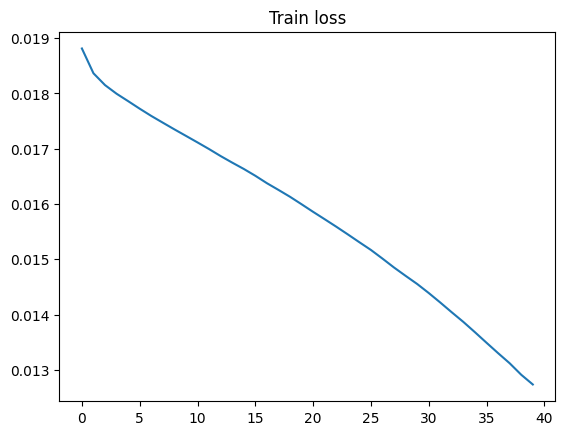

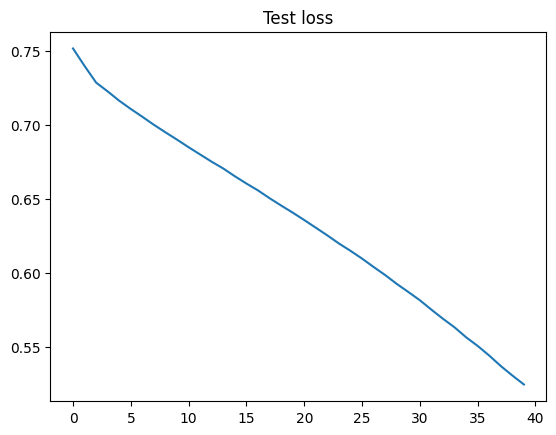

In [79]:
import matplotlib.pyplot as plt

plt.plot([float(e[0]) for e in model.errs])
plt.title("Train loss")
plt.show()
plt.plot([float(e[1]) for e in model.errs])
plt.title("Test loss")
plt.show()

Exemplo de previsão

In [80]:
time_grid.shape

(28, 1002, 778)

In [101]:
for input_, truth in trainloader:
    if np.random.random() < 0.05:
        print("ok")
        break

pred = model(input_)[:, 0, :, :]

ok


In [82]:
# region = compute_frames(am_bounds.total_bounds, config.BOX_SIDE, 450, 514, 80, 144)
# t = 27

# truth = time_grid[t, region["x"].min():region["x"].max()+1, region["y"].min():region["y"].max()+1]
# input_ = time_grid[t-4:t, region["x"].min():region["x"].max()+1, region["y"].min():region["y"].max()+1]
# input_ = input_.reshape(1,*input_.shape)
# pred = model(torch.tensor(input_).float())[0, :, :].detach().numpy()

In [102]:
truth.min(), truth.max()

(tensor(0.), tensor(1.))

In [103]:
input_.shape

torch.Size([40, 10, 64, 64])

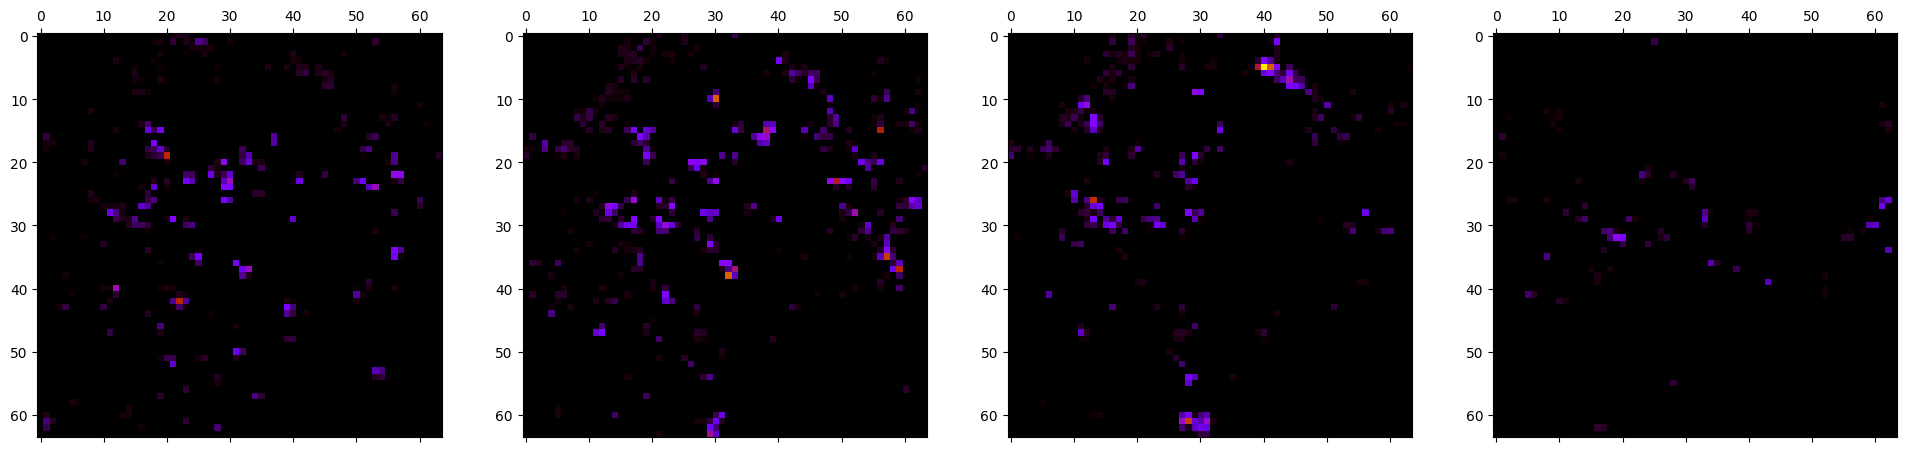

In [104]:
fig, ax = plt.subplots(1, 4, figsize=(24, 8))
for i in range(4):
    ax[i].matshow(input_[0, i, :, :], cmap="gnuplot", vmin=truth.min(), vmax=truth.max())
plt.show()

C:\Users\GiovanniAmorim\AppData\Local\Temp\ipykernel_15804\3204401083.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


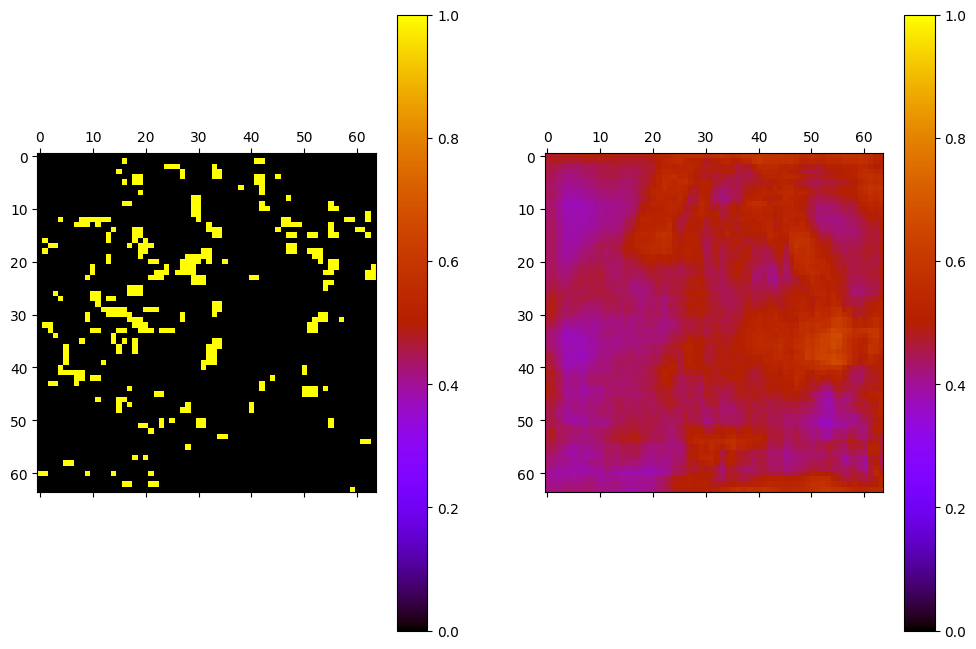

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
m1 = ax[0].matshow(truth[0, :, :], cmap="gnuplot", vmin=truth.min(), vmax=truth.max())
m2 = ax[1].matshow(pred.detach().numpy()[0, :, :], cmap="gnuplot", vmin=truth.min(), vmax=1)
fig.colorbar(m1)
fig.colorbar(m2)
fig.show()

# Save model

In [106]:
torch.save(model.state_dict(), r"basic_cnn_counties_40.pt")